In [10]:
from __future__ import  absolute_import
# though cupy is not used but without this line, it raise errors...
import cupy as cp
import os

import ipdb
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import visdom

from utils.config import opt
from data.dataset import Dataset, TestDataset, inverse_normalize
from model.faster_rcnn_vgg16 import FasterRCNNVGG16
from torch.utils import data as data_
from trainer import FasterRCNNTrainer
from utils import array_tool as at
from utils.vis_tool import visdom_bbox, vis_bbox
from utils.eval_tool import eval_detection_voc

# fix for ulimit
# https://github.com/pytorch/pytorch/issues/973#issuecomment-346405667
import resource

# rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
# resource.setrlimit(resource.RLIMIT_NOFILE, (20480, rlimit[1]))

In [3]:
def eval(dataloader, faster_rcnn, test_num=10000):
    print("\nEVAL")
    pred_bboxes, pred_labels, pred_scores = list(), list(), list()
    gt_bboxes, gt_labels = list(), list()
    for ii, (imgs, sizes, gt_bboxes_, gt_labels_) in tqdm(enumerate(dataloader)):
        sizes = [sizes[0][0].item(), sizes[1][0].item()]
        pred_bboxes_, pred_labels_, pred_scores_ = faster_rcnn.predict(imgs, [sizes])
        gt_bboxes += list(gt_bboxes_.numpy())
        gt_labels += list(gt_labels_.numpy())
        pred_bboxes += pred_bboxes_
        pred_labels += pred_labels_
        pred_scores += pred_scores_
        if ii == test_num: break

    result = eval_detection_voc(
        pred_bboxes, pred_labels, pred_scores,
        gt_bboxes, gt_labels, use_07_metric=True)
    return result

In [4]:
def train(**kwargs):
    opt._parse(kwargs)
    return opt
# Input data directory
opt = train(voc_data_dir='dataset')

======user config========
{'caffe_pretrain': False,
 'caffe_pretrain_path': 'checkpoints/vgg16_caffe.pth',
 'data': 'voc',
 'debug_file': '/tmp/debugf',
 'env': 'faster-rcnn',
 'epoch': 14,
 'load_path': None,
 'lr': 0.001,
 'lr_decay': 0.1,
 'mask': True,
 'mask_conv': True,
 'mask_lin': True,
 'max_size': 1000,
 'min_size': 600,
 'num_workers': 8,
 'plot_every': 40,
 'port': 8097,
 'pretrained_model': 'vgg16',
 'roi_sigma': 1.0,
 'rpn_sigma': 3.0,
 'test_num': 10000,
 'test_num_workers': 8,
 'use_adam': False,
 'use_chainer': False,
 'use_drop': False,
 'use_simple': False,
 'voc_data_dir': 'dataset',
 'weight_decay': 0.0005}
==========end============


In [6]:
dataset = Dataset(opt)
dataloader = data_.DataLoader(dataset, \
                              batch_size=1, \
                              shuffle=True, \
                              # pin_memory=True,
                              num_workers=opt.num_workers)
testset = TestDataset(opt, split='test')
test_dataloader = data_.DataLoader(testset,
                                   batch_size=1,
                                   num_workers=opt.test_num_workers,
                                   shuffle=False, \
                                   pin_memory=True
                                   )
print(f"TRAIN SET: {len(dataloader)} | TEST SET: {len(test_dataloader)}")

TRAIN SET: 19064 | TEST SET: 15019


(1, 3, 600, 800) -2.1179 2.64 float32
(1, 5, 4) 82.9195 787.623 float32
[[ 199.42863464  762.17279053  229.36256409  787.62335205]
 [ 220.4200592   578.77471924  257.13504028  602.92932129]
 [ 178.68936157  733.97406006  317.16781616  785.99920654]
 [ 202.34963989   82.91950226  251.13829041   85.50259399]
 [ 206.42210388   85.95360565  251.44229126  104.79530334]]


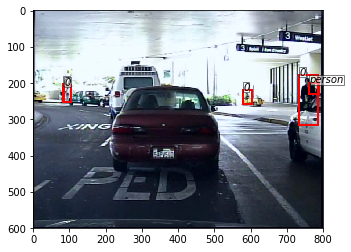

In [7]:
# Single batch
img, bbox, label_, scale = next(iter(dataloader))
scale = at.scalar(scale)
img = img.numpy()
bbox = bbox.numpy()
print(img.shape, img.min(), img.max(), img.dtype)
print(bbox.shape, bbox.min(), bbox.max(), bbox.dtype)
print(at.tonumpy(bbox[0]))
# trainer.train_step(img, bbox, label, scale)

ori_img_ = inverse_normalize(at.tonumpy(img[0]))
gt_img = vis_bbox(ori_img_,
                     at.tonumpy(bbox[0]),
                     at.tonumpy(label_[0]))
plt.show()

In [8]:
faster_rcnn = FasterRCNNVGG16()
print('model construct completed')
trainer = FasterRCNNTrainer(faster_rcnn).cuda()
best_map = 0
lr_ = opt.lr

Using Masked Conv Layers
Using Masked Linear


Without the incoming socket you cannot receive events from the server or register event handlers to your Visdom client.


model construct completed


AssertionError: 
The NVIDIA driver on your system is too old (found version 8000).
Please update your GPU driver by downloading and installing a new
version from the URL: http://www.nvidia.com/Download/index.aspx
Alternatively, go to: https://pytorch.org to install
a PyTorch version that has been compiled with your version
of the CUDA driver.

In [ ]:
for epoch in range(opt.epoch):
    trainer.reset_meters()
    pbar = tqdm(enumerate(dataloader), total=len(dataloader))
    for ii, (img, bbox_, label_, scale) in pbar:
        scale = at.scalar(scale)
        
        img, bbox, label = img.cuda().float(), bbox_.cuda(), label_.cuda()
        losses = trainer.train_step(img, bbox, label, scale)
        if ii % 10 == 0:
            rpnloc = losses[0].cpu().data.numpy()
            rpncls = losses[1].cpu().data.numpy()
            roiloc = losses[2].cpu().data.numpy()
            roicls = losses[3].cpu().data.numpy()
            tot = losses[4].cpu().data.numpy()
            pbar.set_description(f"Epoch: {epoch} | Batch: {ii} | RPNLoc Loss: {rpnloc:.4f} | RPNclc Loss: {rpncls:.4f} | ROIloc Loss: {roiloc:.4f} | ROIclc Loss: {roicls:.4f} | Total Loss: {tot:.4f}")
        if (ii + 1) % 5 == 0:
            print(trainer.get_meter_data())
            ori_img_ = inverse_normalize(at.tonumpy(img[0]))
            gt_img = vis_bbox(ori_img_,
                                 at.tonumpy(bbox_[0]),
                                 at.tonumpy(label_[0]))
            plt.show()

            # plot predicti bboxes
            _bboxes, _labels, _scores = trainer.faster_rcnn.predict([ori_img_], visualize=True)
            pred_img = vis_bbox(ori_img_,
                                   at.tonumpy(_bboxes[0]),
                                   at.tonumpy(_labels[0]).reshape(-1),
                                   at.tonumpy(_scores[0]))
            plt.show()
            
            
    eval_result = eval(test_dataloader, faster_rcnn, test_num=1000)
    lr_ = trainer.faster_rcnn.optimizer.param_groups[0]['lr']
    log_info = 'lr:{}, map:{},loss:{}'.format(str(lr_), str(eval_result['map']),
                                                      str(trainer.get_meter_data()))

    if eval_result['map'] > best_map:
        best_map = eval_result['map']
        best_path = trainer.save(best_map=best_map)
    if epoch == 9:
        trainer.load(best_path)
        trainer.faster_rcnn.scale_lr(opt.lr_decay)
        lr_ = lr_ * opt.lr_decay

    if epoch == 13: 
        break
        

In [9]:
eval_result = eval(test_dataloader, faster_rcnn, test_num=100)
lr_ = trainer.faster_rcnn.optimizer.param_groups[0]['lr']
log_info = 'lr:{}, map:{},loss:{}'.format(str(lr_), str(eval_result['map']),
                                                  str(trainer.get_meter_data()))

if eval_result['map'] > best_map:
    best_map = eval_result['map']
    best_path = trainer.save(best_map=best_map)
if epoch == 9:
    trainer.load(best_path)
    trainer.faster_rcnn.scale_lr(opt.lr_decay)
    lr_ = lr_ * opt.lr_decay


EVAL


100it [00:34,  2.88it/s]

NameError: name 'epoch' is not defined

In [10]:
print("Evaluation Results: ")
print(log_info)
print("\n\n")

Evaluation Results: 
lr:0.001, map:1.8963097811658513e-05,loss:{'rpn_loc_loss': nan, 'rpn_cls_loss': nan, 'roi_loc_loss': nan, 'roi_cls_loss': nan, 'total_loss': nan}





In [ ]:
trainer.get_meter_data()

In [9]:
from __future__ import  absolute_import
# though cupy is not used but without this line, it raise errors...
import cupy as cp
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import ipdb
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils.config import opt
from data.dataset import Dataset, TestDataset, inverse_normalize
from model.faster_rcnn_vgg16 import FasterRCNNVGG16
from torch.utils import data as data_
from trainer import FasterRCNNTrainer
from utils import array_tool as at
from utils.vis_tool import vis_bbox
from utils.eval_tool import eval_detection_voc

# fix for ulimit
# https://github.com/pytorch/pytorch/issues/973#issuecomment-346405667
import resource

rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (4096, rlimit[1]))

def transform_bbox(bbox_):
    """
    Transforms caltech pedestrian bbox to same format as VOC
    Args:
        bbox_: tensor of {x_min, y_min, width, height}
    Returns:
        bbox_: tensor of {y_min, x_min, y_max, x_max}
    """
    bbox_[:, :, 2] += bbox_[:, :, 0]
    bbox_[:, :, 3] += bbox_[:, :, 1]
    bbox_[:, :, 0], bbox_[:, :, 1] = bbox_[:, :, 1], bbox_[:, :, 0]
    bbox_[:, :, 2], bbox_[:, :, 3] = bbox_[:, :, 3], bbox_[:, :, 2]
    return bbox_

def eval(dataloader, faster_rcnn, test_num=10000):
    print("\nEVAL")
    pred_bboxes, pred_labels, pred_scores = list(), list(), list()
    gt_bboxes, gt_labels = list(), list()
    for ii, (imgs, sizes, gt_bboxes_, gt_labels_) in tqdm(enumerate(dataloader)):
        sizes = [sizes[0][0].item(), sizes[1][0].item()]
        pred_bboxes_, pred_labels_, pred_scores_ = faster_rcnn.predict(imgs, [sizes])
        gt_bboxes += list(gt_bboxes_.numpy())
        gt_labels += list(gt_labels_.numpy())
        pred_bboxes += pred_bboxes_
        pred_labels += pred_labels_
        pred_scores += pred_scores_
        if ii == test_num: break

    result = eval_detection_voc(
        pred_bboxes, pred_labels, pred_scores,
        gt_bboxes, gt_labels, use_07_metric=True)
    return result

def train(opt, faster_rcnn, dataloader, test_dataloader, trainer, lr_, best_map):
    for epoch in range(opt.epoch):
        trainer.reset_meters()
        pbar = tqdm(enumerate(dataloader), total=len(dataloader))
        for ii, (img, bbox_, label_, scale) in pbar:
            # Currently configured to predict (y_min, x_min, y_max, x_max)
#             bbox_tmp = bbox_.clone()
#             bbox_ = transform_bbox(bbox_)
            scale = at.scalar(scale)
            
            img, bbox, label = img.cuda().float(), bbox_.cuda(), label_.cuda()
            losses = trainer.train_step(img, bbox, label, scale)
            if ii % 100 == 0:
                rpnloc = losses[0].cpu().data.numpy()
                rpncls = losses[1].cpu().data.numpy()
                roiloc = losses[2].cpu().data.numpy()
                roicls = losses[3].cpu().data.numpy()
                tot = losses[4].cpu().data.numpy()
                pbar.set_description("Epoch: {epoch} | Batch: {ii} | RPNLoc Loss: {rpnloc:.4f} | RPNclc Loss: {rpncls:.4f} | ROIloc Loss: {roiloc:.4f} | ROIclc Loss: {roicls:.4f} | Total Loss: {tot:.4f}"
                                     .format(epoch=epoch, ii=ii, rpnloc=rpnloc, rpncls=rpncls, roicls=roicls, tot=tot))
            if (ii + 1) % 1000 == 0:
                print(trainer.get_meter_data())
                try:
                    ori_img_ = inverse_normalize(at.tonumpy(img[0]))
                    gt_img = vis_bbox(ori_img_,
                                        at.tonumpy(bbox_[0]),
                                        at.tonumpy(label_[0]))
                    plt.show()

                    # plot predicti bboxes
                    _bboxes, _labels, _scores = trainer.faster_rcnn.predict([ori_img_], visualize=True)
                    pred_img = vis_bbox(ori_img_,
                                        at.tonumpy(_bboxes[0]),
                                        at.tonumpy(_labels[0]).reshape(-1),
                                        at.tonumpy(_scores[0]))
                    plt.show()
                except:
                    print("Cannot display images")
                
                
        eval_result = eval(test_dataloader, faster_rcnn, test_num=1000)
        lr_ = trainer.faster_rcnn.optimizer.param_groups[0]['lr']
        log_info = 'lr:{}, map:{},loss:{}'.format(str(lr_), str(eval_result['map']),
                                                        str(trainer.get_meter_data()))
        print("Evaluation Results: ")
        print(log_info)
        print("\n\n")
        
        if eval_result['map'] > best_map:
            best_map = eval_result['map']
            best_path = trainer.save(best_map=best_map)
        if epoch == 9:
            trainer.load(best_path)
            trainer.faster_rcnn.scale_lr(opt.lr_decay)
            lr_ = lr_ * opt.lr_decay

        if epoch == 13: 
            break


def main():
    dataset = Dataset(opt)
    dataloader = data_.DataLoader(dataset, \
                                batch_size=1, \
                                shuffle=True, \
                                # pin_memory=True,
                                num_workers=opt.num_workers)
    testset = TestDataset(opt, split='test')
    test_dataloader = data_.DataLoader(testset,
                                    batch_size=1,
                                    num_workers=opt.test_num_workers,
                                    shuffle=False, \
                                    pin_memory=True
                                    )
    print(f"TRAIN SET: {len(dataloader)} | TEST SET: {len(test_dataloader)}")
    print("Using Mask VGG") if opt.mask else print("Using normal VGG16")
    faster_rcnn = FasterRCNNVGG16(mask=opt.mask)
    print('model construct completed')
    trainer = FasterRCNNTrainer(faster_rcnn).cuda()
    best_map = 0
    lr_ = opt.lr
    train(opt, faster_rcnn, dataloader, test_dataloader, trainer, lr_, best_map)


if __name__ == "__main__":
    print(opt)
    main()


{i:.3}
TRAIN SET: 19064 | TEST SET: 15019
Using Mask VGG
Using Masked Conv Layers
Using Masked Linear


Traceback (most recent call last):
  File "/data6/lekevin/miniconda3/envs/fastenv/lib/python3.6/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/data6/lekevin/miniconda3/envs/fastenv/lib/python3.6/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/data6/lekevin/miniconda3/envs/fastenv/lib/python3.6/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/data6/lekevin/miniconda3/envs/fastenv/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/data6/lekevin/miniconda3/envs/fastenv/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_reques

model construct completed
Exception in user code:
------------------------------------------------------------


RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 11.90 GiB total capacity; 11.18 GiB already allocated; 64.94 MiB free; 40.28 MiB cached)